## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [24]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
  frequency = {}
  for label in sequence:
    if label not in frequency:
      frequency[label] = 0
    frequency[label] += 1
  gini_value = 1
  
  for freq in frequency.items():
    gini_value -= (freq[1] / len(sequence)) ** 2 # 1 - pi^2 for all i
  return gini_value
      


def entropy(sequence):
  frequency = {}
  for label in sequence:
    if label not in frequency:
      frequency[label] = 0
    frequency[label] += 1
  entropy_value = 0
  for freq in frequency.items():
    entropy_value -= np.log2(freq[1] / len(sequence)) * freq[1] / len(sequence) #-pi log pi for all i 
  return entropy_value
  

In [25]:
# 1 = class 1,
# 2 = class 2
import numpy as np
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [26]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [27]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [51]:
import pandas as pd
importance = [0 for i in range(20)]
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')


print(train_df.shape)
print(val_df.shape)

####split training data into x data and corresponding y data
x_train = train_df.drop(labels=["price_range"], axis="columns")
feature_names = x_train.columns.values
x_train = x_train.values
y_train = train_df["price_range"].values

####split validation data into x data and corresponding y data
x_val = val_df.drop(labels=["price_range"], axis="columns")
x_val = x_val.values
y_val = val_df["price_range"].values

(1200, 21)
(300, 21)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [36]:
class decision_node: #store decision node in a tree
  def __init__(self, less_branch, more_branch, question = None):
    self.less_branch = less_branch
    self.more_branch = more_branch
    self.question = question
class leaf_node: #store leaf node in a tree
  def __init__(self, whole_data):
    frequency = {}
    for label in whole_data[:, -1]:
      if label not in frequency:
        frequency[label] = 0
      frequency[label] +=1
    max_key = 0
    max_value = 0
    for key, value in frequency.items():
      if value > max_value:
        max_key = key
        max_value = value
    self.final_class = max_key


class DecisionTree:
    def __init__(self, criterion='gini', max_depth=None, boostrap=None, max_features=None):
      self.depth = max_depth
      self.cri = criterion
      self.boostrap = boostrap
      self.max_features = max_features

    def fit(self, x_data, y_data, sample_weight = None):
      whole_data = np.append(x_data, [[i] for i in y_data], 1)
      if not sample_weight is None: 
        self.tree = build_tree(whole_data, self.cri, sample_weight, 0, 1) #adaboost
      elif not self.boostrap is None:
        if not self.max_features is None:
          self.tree = build_tree(whole_data, self.cri, sample_weight, 0, -1, self.boostrap, self.max_features) #random forest
      else:
        self.tree = build_tree(whole_data, self.cri, sample_weight = None, current_depth = 0, target_depth = self.depth) #original DT
        

      

    def predict(self, x_data):
      pred = []
      for target_index in range(len(x_data)):
        data = x_data[target_index]
        pred.append(classification(data, self.tree))          #given x predict y
      prediction = np.array(pred)
      return prediction

class Question:         #store the feature and corresponding threshold of decision node
  def __init__(self, feature, threshold):
    self.feature = feature
    self.threshold = threshold
  def split_branch(self, data):
    less_index = []
    more_index = []
    for i in range(len(data)):
      if data[i][self.feature] > self.threshold:
        less_index.append(i)
      else:
        more_index.append(i)
    return data[less_index], data[more_index]

def build_tree(before_whole_data, cri, sample_weight = None, current_depth=0, target_depth=-1, boostrap=None, max_features=None):
  largest_gain = 0
  best_question = None
  if current_depth == target_depth:
    return leaf_node(before_whole_data)
  if current_depth == 0:
    if not sample_weight is None:
      num = len(before_whole_data)
      whole_data = before_whole_data[np.random.choice(np.arange(num), num, p = sample_weight)] #adaboost
    elif not boostrap is None:
      w= np.ones(len(before_whole_data)) * 1 / len(before_whole_data)
      num = len(before_whole_data)
      whole_data = before_whole_data[np.random.choice(np.arange(num), num, p = w)] #random forest
    else:
      whole_data = before_whole_data 
  else: whole_data = before_whole_data  
  if not boostrap is None:
    features = np.random.choice(len(whole_data[0])-1, int(max_features), replace=False) #random forest
  else :  
    features = np.arange(len(whole_data[0])-1)
  
  
  if cri == 'gini':
    
    currrent_value = gini(whole_data[:, -1]) #gini
  else:
    currrent_value = entropy(whole_data[:, -1])  #entropy
  for col_index in features:     #search for possible feature, threshold pair that can improve info gain
    values = list(set(whole_data[:, col_index]))
    if len(values) == 1: continue
    for i in range(len(values) - 1):
      mid_value = (values[i] + values[i + 1]) / 2
      question = Question(col_index, mid_value)
      less_data, more_data = question.split_branch(whole_data)
      p = len(less_data) / (len(less_data) + len(more_data))
      if cri == 'gini':
        info_gain = currrent_value - p * gini(less_data[:, -1]) - (1 - p) * gini(more_data[:, -1])
      else:
        info_gain = currrent_value - p * entropy(less_data[:, -1]) - (1 - p) * entropy(more_data[:, -1])
      if info_gain >= largest_gain:
        largest_gain = info_gain
        best_question = question
  if largest_gain == 0:
    return leaf_node(whole_data)
  importance[best_question.feature] += 1 #count the importance of each feature
  less_data, more_data = best_question.split_branch(whole_data)
  less_branch = build_tree(less_data, cri, sample_weight, current_depth + 1, target_depth, boostrap, max_features)
  more_branch = build_tree(more_data, cri, sample_weight, current_depth + 1, target_depth, boostrap, max_features)
  return decision_node(less_branch, more_branch, best_question) # split the node into two branches according to the feature and threshold
    
def classification(data, node): #for classify data

  if isinstance(node, leaf_node):
    return node.final_class
  if data[node.question.feature] > node.question.threshold:
    return classification(data, node.less_branch)
  else:
    return classification(data, node.more_branch)



### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [37]:
from sklearn.metrics import accuracy_score
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
pred = clf_depth3.predict(x_val)
print("Decision Tree")
print("max_depth = 3, accuracy score:", accuracy_score(y_val, pred))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
pred = clf_depth10.predict(x_val)
print("max_depth = 10, accuracy score:", accuracy_score(y_val, pred))


Decision Tree
max_depth = 3, accuracy score: 0.92
max_depth = 10, accuracy score: 0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [38]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
pred = clf_gini.predict(x_val)
print('Decision Tree')
print("Criterion=‘gini', accuracy score:",accuracy_score(y_val, pred))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
pred = clf_entropy.predict(x_val)
print("Criterion='entropy’, accuracy score:",accuracy_score(y_val, pred))

Decision Tree
Criterion=‘gini', accuracy score: 0.92
Criterion='entropy’, accuracy score: 0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

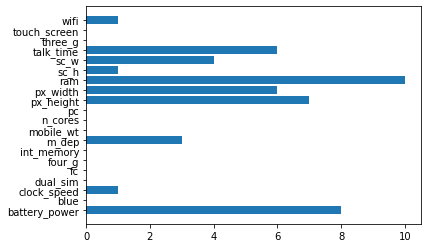

In [40]:
import matplotlib.pyplot as plt
importance = [0 for i in range(20)]
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
x = [i for i in range(20)]
label = feature_names
plt.barh(x, importance, tick_label = label,)
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [41]:
class AdaBoost():
    def __init__(self, n_estimators):
      self.M = n_estimators
      self.G_M = []
      self.alphas = []
      self.training_errors = []
      self.prediction_errors = []

    def fit(self, x_data, y_data):
      for m in range(self.M):

        if m == 0:
          w = np.ones(len(y_data)) * 1 / len(y_data) 
        else:
          w =  w * np.exp(alpha_m * (np.not_equal(y_data, y_pred)).astype(int)) #update w
          w /= w.sum()                      #sum of w must be 1
        weak_tree = DecisionTree(max_depth = 1) 
        
        weak_tree.fit(x_data, y_data, sample_weight = w)
        y_pred = weak_tree.predict(x_data)
        self.G_M.append(weak_tree) # record stump
        error_m = (sum(w * (np.not_equal(y_data, y_pred)).astype(int)))/sum(w)
        
        self.training_errors.append(error_m)
        alpha_m = np.log((1 - error_m) / error_m) #record alpha

        self.alphas.append(alpha_m)

      assert len(self.G_M) == len(self.alphas)




    def predict(self, x_data): #predict according to recorded stumps and alphas
      pred = []
      for i in range(len(x_data)):
        data = [x_data[i]]
        judge = 0
        for m in range(self.M):
          if self.G_M[m].predict(data)[0] == 1 :
            judge += self.alphas[m]
          else:
            judge -= self.alphas[m]
        if judge > 0:
          pred.append(1)
        else:
          pred.append(0)
      prediction = np.array(pred)
      return prediction


In [42]:
from sklearn.metrics import accuracy_score
ada10 = AdaBoost(10)
ada10.fit(x_train, y_train)
pred10 = ada10.predict(x_val)

ada100 = AdaBoost(100) #1000 for best
ada100.fit(x_train, y_train)
pred100 = ada100.predict(x_val)


### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [43]:
from sklearn.metrics import accuracy_score
print('AdaBooest')
print("n_estimators=10, accuracy score:",accuracy_score(y_val, pred10))
print("n_estimators=100, accuracy score:",accuracy_score(y_val, pred100))

AdaBooest
n_estimators=10, accuracy score: 0.9366666666666666
n_estimators=100, accuracy score: 0.9733333333333334


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [44]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
      self.n_estimators = n_estimators
      self.max_features = max_features
      self.boostrap = boostrap
      self.cri = criterion
      self.max_depth = max_depth
      self.G_M = []

    def fit(self, x_data, y_data):
      for m in range(self.n_estimators):
        random_tree = DecisionTree(boostrap=self.boostrap, max_features = self.max_features)
        random_tree.fit(x_data, y_data)
        self.G_M.append(random_tree) #record random trees


    def predict(self, x_data): #predict y according to recored trees
      pred = []
      for i in range(len(x_data)):
        data = [x_data[i]]
        judge = 0
        for m in range(self.n_estimators):
          if self.G_M[m].predict(data)[0] == 1 :  #vote for class 0 or 1
            judge += 1
          else:
            judge -= 1
        if judge >= 0:
          pred.append(1)
        else:
          pred.append(0)
      prediction = np.array(pred)
      return prediction

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [45]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
pred10_ran = clf_10tree.predict(x_val)
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
pred100_ran = clf_100tree.predict(x_val)

In [46]:
from sklearn.metrics import accuracy_score

print("Random Forest")
print("n_estimators=10, accuracy score:",accuracy_score(y_val, pred10_ran))
print("n_estimators=100, accuracy score:",accuracy_score(y_val, pred100_ran))

Random Forest
n_estimators=10, accuracy score: 0.93
n_estimators=100, accuracy score: 0.96


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [47]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train, y_train)
pred_ran = clf_random_features.predict(x_val)
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
pred_all = clf_all_features.predict(x_val)

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [48]:
from sklearn.metrics import accuracy_score

print("Random Forest")
print("random features, accuracy score:",accuracy_score(y_val, pred_ran))
print("all features, accuracy score:",accuracy_score(y_val, pred_all))

Random Forest
random features, accuracy score: 0.9333333333333333
all features, accuracy score: 0.9666666666666667


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [63]:
from sklearn.metrics import accuracy_score

def train_your_model(data):
    ## Define your model and training 
    x_train = data.drop(labels=["price_range"], axis="columns")
    x_train = x_train.values
    y_train = data["price_range"].values

    ada = 150
    adatest = AdaBoost(ada)
    adatest.fit(x_train, y_train)
    predtest = adatest.predict(x_val)
    return adatest

In [64]:
trainval_df = train_df.append(val_df)
my_model = train_your_model(trainval_df)

In [67]:
test_df = pd.read_csv('x_test.csv')
x_test = test_df.values
y_pred = ada100.predict(x_test)

In [68]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [50]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
